# Introduction

There have been lot of studies undertaken in the past on factors affecting life expectancy considering demographic variables, income composition and mortality rates. This study will focus on immunization factors, mortality factors, economic factors, social factors and other health related factors as well that relate to life expectancy. Since the observations this dataset are based on different countries, it will be easier for a country to determine the predicting factor which is contributing to lower value of life expectancy. This will help in suggesting a country which area should be given importance in order to efficiently improve the life expectancy of its population.

In [356]:
[column for column in data.columns]

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']

In [331]:
data.dtypes

carat      float64
cut          int64
color       object
clarity      int64
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [54]:
data['infant_deaths'].unique()


array([  62,   64,   66,   69,   71,   74,   77,   80,   82,   84,   85,
         87,   88,    0,    1,   21,   20,   19,   67,   72,   75,   78,
         81,   90,   92,   94,   95,   96,   97,    8,    9,   10,   11,
         12,    5,    6,    7,   98,  104,  111,  118,  126,  135,  144,
        154,  164,  174,  185,  196,  207,  219,  231,   25,   13,   14,
         15,    2,   42,   44,   46,   49,   51,   54,   57,   61,   65,
         70,  103,   38,   39,   40,   41,   43,   45,   47,   48,   22,
         23,   24,   58,   59,   60,   63,   16,   17,   18,   27,   50,
         53,   56,  157,  171,  201,  215,  248,  266,  285,  307,  332,
        360,  391,  422,  457,  490,  236,  237,  238,  239,  235,  233,
        232,  229,  227,  226,   55,    3,    4,  136,  140,  145,  150,
        156,  162,  169,  177,  186,  206,  217,  228,  246,  253,   37,
         26,   28,   29,   30,   31,   32,   33,   34,   35,   36,  910,
        957, 1000, 1100, 1200, 1300, 1400, 1500, 16

#### Deep Learning

In [497]:
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, SimpleRNN, BatchNormalization, Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split


The "Origin" column is categorical, not numeric. So the next step is to one-hot encode the values in the column with pd.get_dummies.

In [477]:
data_deep = data
data_deep = pd.get_dummies(data_deep, columns=['color'], prefix='color')
data_deep.head()

,carat,cut,clarity,depth,table,price,x,y,z,color_D,color_E,color_F,color_G,color_H,color_I,color_J
0,0.23,5,4,61.5,55.0,326,3.95,3.98,2.43,0,1,0,0,0,0,0
1,0.21,4,5,59.8,61.0,326,3.89,3.84,2.31,0,1,0,0,0,0,0
2,0.23,3,7,56.9,65.0,327,4.05,4.07,2.31,0,1,0,0,0,0,0
3,0.29,4,6,62.4,58.0,334,4.20,4.23,2.63,0,0,0,0,0,1,0
4,0.31,3,4,63.3,58.0,335,4.34,4.35,2.75,0,0,0,0,0,0,1


##### Split the data into training and test sets
Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [478]:
train_dataset = data_deep.sample(frac=0.8, random_state=0)
test_dataset = data_deep.drop(train_dataset.index)


##### Split features from labels
Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [481]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('price')
test_labels = test_features.pop('price')


##### Normalization
In the table of statistics it's easy to see how different the ranges of each feature are:

In [492]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
carat,0.797184,0.473724
cut,3.773035,1.266756
clarity,6.059395,1.649229
depth,61.747900,1.430988
table,57.455726,2.233570
price,3929.801237,3989.630670
x,5.728950,1.122392
y,5.732241,1.142865
z,3.537722,0.708590
color_D,0.126159,0.332032


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

##### The Normalization layer
The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [493]:
normalizer = tf.keras.layers.Normalization(axis=-1)


Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:

In [494]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [495]:
print(normalizer.mean.numpy())

[[7.9718351e-01 3.7730343e+00 6.0593863e+00 6.1747860e+01 5.7455765e+01
  5.7289433e+00 5.7322426e+00 3.5377181e+00 1.2615842e-01 1.8054757e-01
  1.7538005e-01 2.0993228e-01 1.5443079e-01 9.9671006e-02 5.3879287e-02]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [496]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())


First example: [[ 1.1   5.    4.   62.   55.    6.61  6.65  4.11  0.    0.    0.    0.
   1.    0.    0.  ]]

Normalized: [[ 0.64  0.97 -1.25  0.18 -1.1   0.78  0.8   0.81 -0.38 -0.47 -0.46 -0.52
   2.34 -0.33 -0.24]]


##### Linear regression
Before building a deep neural network model, start with linear regression using one and several variables.

##### Linear regression with one variable
Begin with a single-variable linear regression to predict 'price' from 'carat'.

Training a model with tf.keras typically starts by defining the model architecture. Use a tf.keras.Sequential model, which represents a sequence of steps.

There are two steps in your single-variable linear regression model:

Normalize the 'carat' input features using the tf.keras.layers.Normalization preprocessing layer.
Apply a linear transformation () to produce 1 output using a linear layer (tf.keras.layers.Dense).
The number of inputs can either be set by the input_shape argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the 'carat' features. Then, instantiate the tf.keras.layers.Normalization and fit its state to the horsepower data:




In [498]:
carat = np.array(train_features['carat'])

carat_normalizer = Normalization(input_shape=[1, ], axis=None)
carat_normalizer.adapt(carat)


Build the Keras Sequential model:

In [499]:
carat_model = tf.keras.Sequential([
    carat_normalizer,
    Dense(units=1)
])

carat_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_87 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict 'price' from 'carat'.

Run the untrained model on the first 10 'carat' values. The output won't be good, but notice that it has the expected shape of (10, 1):

In [500]:
carat_model.predict(carat[:10])


array([[-0.80408126],
       [-1.308596  ],
       [-1.0696155 ],
       [-1.8662177 ],
       [-0.27301282],
       [ 1.2670853 ],
       [ 1.320192  ],
       [ 0.49703613],
       [-3.2204418 ],
       [ 1.2936386 ]], dtype=float32)

Once the model is built, configure the training procedure using the Keras Model.compile method. The most important arguments to compile are the loss and the optimizer, since these define what will be optimized (mean_absolute_error) and how (using the tf.keras.optimizers.Adam).

In [501]:
carat_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras Model.fit to execute the training for 100 epochs:

In [504]:
%%time
history = carat_model.fit(
    train_features['carat'],
    train_labels,
    epochs=100,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)


Epoch 1/100
1079/1079 [==============================] - 2s 2ms/step - loss: 3886.1492 - val_loss: 3781.0156
Epoch 2/100
1079/1079 [==============================] - 2s 1ms/step - loss: 3778.2402 - val_loss: 3673.1306
Epoch 3/100
1079/1079 [==============================] - 2s 1ms/step - loss: 3670.3254 - val_loss: 3565.2480
Epoch 4/100
1079/1079 [==============================] - 2s 1ms/step - loss: 3562.6179 - val_loss: 3458.2483
Epoch 5/100
1079/1079 [==============================] - 2s 1ms/step - loss: 3457.8677 - val_loss: 3356.0781
Epoch 6/100
1079/1079 [==============================] - 2s 1ms/step - loss: 3357.1277 - val_loss: 3256.7339
Epoch 7/100
1079/1079 [==============================] - 2s 1ms/step - loss: 3257.2278 - val_loss: 3157.6096
Epoch 8/100
1079/1079 [==============================] - 2s 1ms/step - loss: 3156.7932 - val_loss: 3057.8679
Epoch 9/100
1079/1079 [==============================] - 2s 2ms/step - loss: 3055.6438 - val_loss: 2957.7024
Epoch 10/100
1079/1

Visualize the model's training progress using the stats stored in the history object:

In [505]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
95,955.873901,931.688049,95
96,955.870483,931.686523,96
97,955.872314,931.679993,97
98,955.869568,931.694641,98
99,955.867676,931.677979,99


In [515]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss') 
    plt.xlabel('Epoch')
    plt.ylabel('Error [price]')
    plt.legend()
    plt.grid(True)
    plt.show()


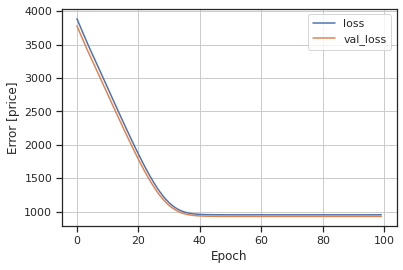

In [516]:
plot_loss(history) 


Collect the results on the test set for later:

In [517]:
test_results = {}

test_results['carat_model'] = carat_model.evaluate(
    test_features['carat'],
    test_labels, verbose=0)


Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [527]:
x = tf.linspace(0.0, 4, 50)
y = carat_model.predict(x)


In [549]:
def plot_carat(x, y):
    plt.figure(figsize=(15, 10))
    plt.scatter(train_features['carat'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('carat')
    plt.ylabel('price')
    plt.legend()


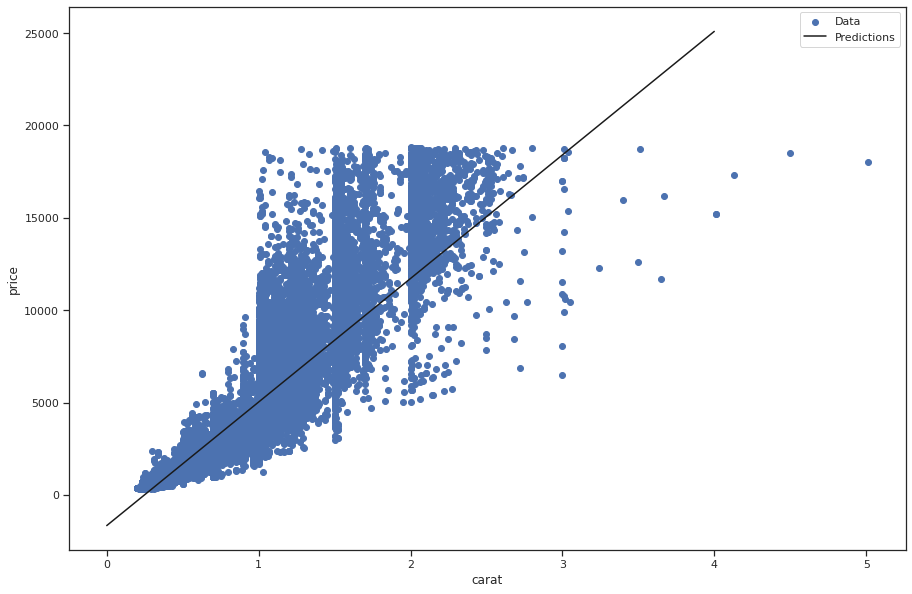

In [531]:
plot_carat(x,y)

##### Linear regression with multiple inputs
You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same `y = mx + b` except that `m` is a matrix and `b` is a vector.

Create a two-step Keras Sequential model again with the first layer being normalizer (tf.keras.layers.Normalization(axis=-1)) you defined earlier and adapted to the whole dataset:

In [532]:
linear_model = tf.keras.Sequential([
    normalizer,
    Dense(units=1)
])

Configure the model with Keras Model.compile and train with Model.fit for 100 epochs:

In [533]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [536]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)


Epoch 1/100
1079/1079 [==============================] - 2s 2ms/step - loss: 833.9733 - val_loss: 812.8000
Epoch 2/100
1079/1079 [==============================] - 3s 2ms/step - loss: 831.1848 - val_loss: 809.9588
Epoch 3/100
1079/1079 [==============================] - 1s 1ms/step - loss: 828.4339 - val_loss: 807.1069
Epoch 4/100
1079/1079 [==============================] - 1s 1ms/step - loss: 825.7274 - val_loss: 804.3632
Epoch 5/100
1079/1079 [==============================] - 1s 1ms/step - loss: 823.0703 - val_loss: 801.6379
Epoch 6/100
1079/1079 [==============================] - 1s 1ms/step - loss: 820.3934 - val_loss: 798.8339
Epoch 7/100
1079/1079 [==============================] - 1s 1ms/step - loss: 817.7462 - val_loss: 796.1119
Epoch 8/100
1079/1079 [==============================] - 1s 1ms/step - loss: 815.1047 - val_loss: 793.5562
Epoch 9/100
1079/1079 [==============================] - 1s 1ms/step - loss: 812.5365 - val_loss: 790.8481
Epoch 10/100
1079/1079 [=============

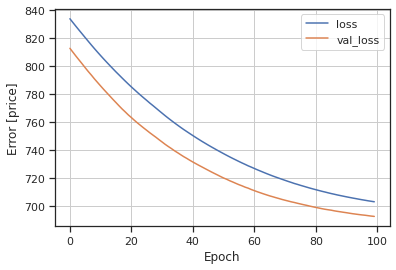

In [538]:
plot_loss(history)


In [539]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)


#### Regression with a deep neural network (DNN)
In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with carat_normalizer for a single-input model and normalizer for a multiple-input model).
* Two hidden, non-linear, Dense layers with the ReLU (relu) activation function nonlinearity.
* A linear Dense single-output layer.

Both models will use the same training procedure so the compile method is included in the build_and_compile_model function below.

In [540]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model


##### Regression using a DNN and a single input
Create a DNN model with only `carat` as input and `carat_normalizer` (defined earlier) as the normalization layer:

In [541]:
dnn_carat_model = build_and_compile_model(carat_normalizer)


This model has quite a few more trainable parameters than the linear models:

In [543]:
dnn_carat_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_89 (Dense)            (None, 64)                128       
                                                                 
 dense_90 (Dense)            (None, 64)                4160      
                                                                 
 dense_91 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model with Keras Model.fit:

In [544]:
history = dnn_carat_model.fit(
    train_features['carat'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

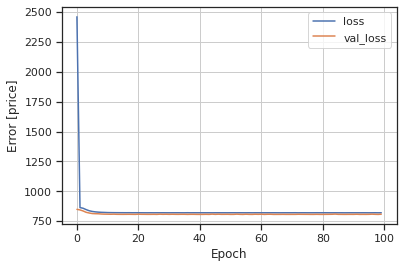

In [545]:
plot_loss(history)

If you plot the predictions as a function of 'Horsepower', you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [551]:
x = tf.linspace(0.0, 4, 50)
y = dnn_carat_model.predict(x)

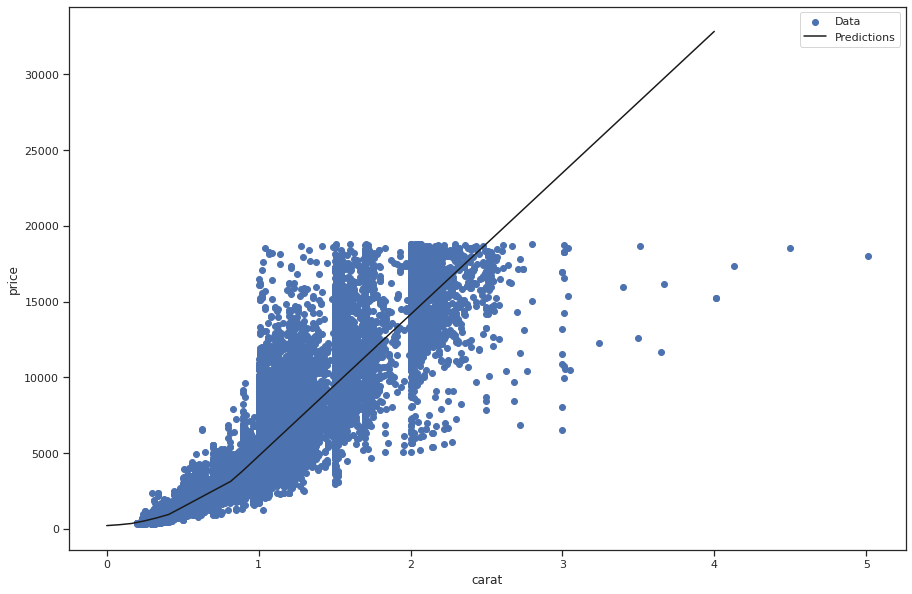

In [552]:
plot_carat(x, y)

In [553]:
test_results['dnn_carat_model'] = dnn_carat_model.evaluate(
    test_features['carat'], test_labels,
    verbose=0)

##### Regression using a DNN and multiple inputs
Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [554]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 15)               31        
 n)                                                              
                                                                 
 dense_92 (Dense)            (None, 64)                1024      
                                                                 
 dense_93 (Dense)            (None, 64)                4160      
                                                                 
 dense_94 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,280
Trainable params: 5,249
Non-trainable params: 31
_________________________________________________________________


In [555]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2, 
    epochs=100)

Epoch 1/100
1079/1079 [==============================] - 3s 2ms/step - loss: 1980.1951 - val_loss: 600.9349
Epoch 2/100
1079/1079 [==============================] - 3s 3ms/step - loss: 521.8899 - val_loss: 463.9257
Epoch 3/100
1079/1079 [==============================] - 2s 2ms/step - loss: 451.0403 - val_loss: 429.6447
Epoch 4/100
1079/1079 [==============================] - 2s 2ms/step - loss: 426.2385 - val_loss: 413.5133
Epoch 5/100
1079/1079 [==============================] - 2s 2ms/step - loss: 410.6217 - val_loss: 401.0284
Epoch 6/100
1079/1079 [==============================] - 2s 2ms/step - loss: 400.4504 - val_loss: 393.6552
Epoch 7/100
1079/1079 [==============================] - 2s 2ms/step - loss: 392.3275 - val_loss: 385.0370
Epoch 8/100
1079/1079 [==============================] - 2s 2ms/step - loss: 384.6735 - val_loss: 379.6197
Epoch 9/100
1079/1079 [==============================] - 2s 2ms/step - loss: 377.6542 - val_loss: 373.5136
Epoch 10/100
1079/1079 [============

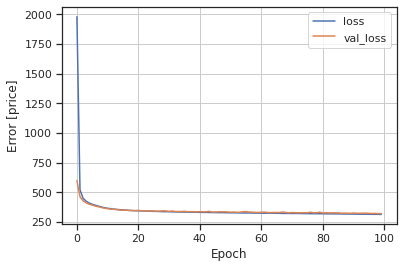

In [556]:
plot_loss(history)

In [557]:
test_results['dnn_model'] = dnn_model.evaluate(
    test_features, test_labels, verbose=0)

##### Performance
Since all models have been trained, you can review their test set performance:

In [558]:
pd.DataFrame(test_results, index=['Mean absolute error [price]']).T

,Mean absolute error [price]
carat_model,951.496460
linear_model,707.677063
dnn_carat_model,822.255127
dnn_model,330.091614


##### Make predictions
You can now make predictions with the dnn_model on the test set using Keras Model.predict and review the loss:

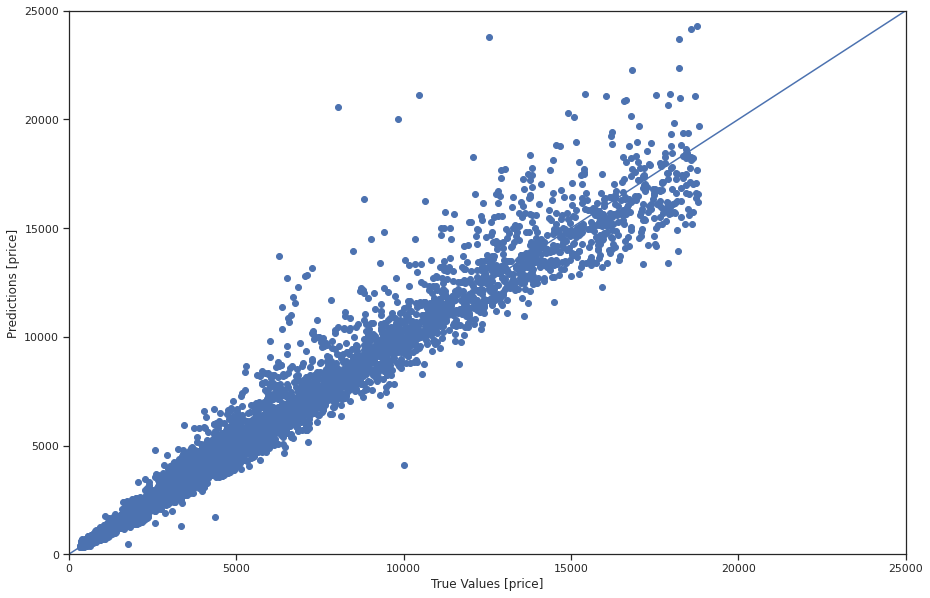

In [568]:
test_predictions = dnn_model.predict(test_features).flatten()

plt.figure(figsize=(15, 10))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [price]')
plt.ylabel('Predictions [price]')
lims = [0, 25000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

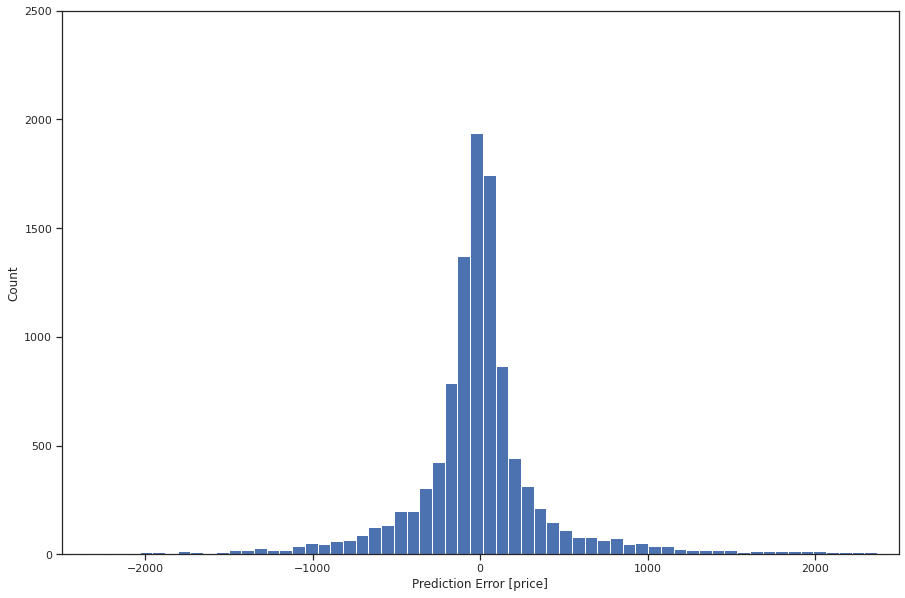

In [583]:
error = test_predictions - test_labels
plt.figure(figsize=(15, 10))
plt.hist(error, bins=1000)
plt.xlabel('Prediction Error [price]')
xlim = [-2500, 2500]
ylim = [0, 2500]
plt.xlim(xlim)
plt.ylim(ylim)
_ = plt.ylabel('Count')
